In [18]:
# COCO 2017 데이터셋을 활용한 CNN-RNN 하이브리드 모델 for Image Captioning
#학습 목표 : 이미지 캡션 생성을 위한 CNN-RNN 하이브리드 모델 구현 목표
#CNN-RNN 하이브리드 이미지 캡셔닝 학습 팁
#- 이미지 → CNN으로 특징 추출
#- 캡션 → RNN으로 시퀀스 생성
#- 학습 데이터셋: MS COCO 추천
#- 손실 함수: nn.CrossEntropyLoss()
#- 옵티마이저: torch.optim.Adam
# MS COCO 데이터셋은 이미지와 캡션이 포함되어 있음

#추천 학습 흐름
#- 데이터 로더 구성 → 완료
#- 캡션 토큰화 및 임베딩 처리
#- CNN-RNN 모델 구성
#- 학습 루프 구현 (Loss, Optimizer)
#- 검증 및 예측 결과 시각화
#- 성능 분석 및 개선 시도

#이미지 캡셔닝(Image Captioning)은 이미지의 내용을 이해하고, 그에 맞는 자연어 문장을 자동으로 생성하는 기술
#컴퓨터 비전과 자연어 처리(NLP)를 결합한 대표적인 멀티모달 AI 분야
#이미지 캡셔닝은 단순히 이미지에 대한 설명을 붙이는 것이 아니라, 이미지 속의 의미를 파악하고 그 의미를 자연어로 표현하는 작업
#예시) 이미지: 말 위에 탄 사람이 해변을 달리는 모습
#캡션: "A person riding a horse on the beach"

In [19]:
# 필요한 라이브러리 설치
# pip install pycocotools nltk pillow

In [20]:
# 1) 필요한 라이브러리 임포트
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
# COCO (Common Objects in Context), - Microsoft에서 만든 대규모 이미지 데이터셋으로, 
# 이미지에 대한 객체 바운딩 박스, 분할 마스크, 캡션 등의 다양한 주석(annotation)을 포함
# COCO 데이터셋의 JSON 주석 파일을 쉽게 파싱하고 다룰 수 있도록 만든 Python 라이브러리입니다.
from pycocotools.coco import COCO
import nltk, os, zipfile
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Pytorch Version: {torch.__version__},  device: {DEVICE}")

Using Pytorch Version: 2.7.1+cu118,  device: cuda


In [ ]:
# 데이터 폴더 존재시 삭제
if os.path.exists('./data/coco/train2017'):
    shutil.rmtree('./data/coco/train2017')
    print('./data/coco/train2017 is removed')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/annotations_trainval2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/annotations_trainval2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/annotations_trainval2017.zip')
    with zipfile.ZipFile('./data/coco/annotations_trainval2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/annotations_trainval2017.zip')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/val2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/val2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/val2017.zip')
    with zipfile.ZipFile('./data/coco/val2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/val2017.zip')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/test2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/test2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/test2017.zip')
    with zipfile.ZipFile('./data/coco/test2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/test2017.zip')

In [ ]:
# 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/coco/train2017.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/coco/train2017.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/coco/train2017.zip')
    with zipfile.ZipFile('./data/coco/train2017.zip', 'r') as target_file:
        target_file.extractall('./data/coco')
        print('압축 해제 완료. ./data/coco/train2017.zip')

In [30]:
# 2) Vocabulary 클래스 정의
class Vocabulary:
    def __init__(self, freq_threshold=2): # 초기화
        self.freq_threshold = freq_threshold # 단어가 등장한 횟수가 이 값 이상일 때만 사전에 포함
        self.word2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3} # 단어 → 인덱스 매핑. 특수 토큰 4개는 항상 포함
        self.idx2word = {0:'<PAD>', 1:'<SOS>', 2:'<EOS>', 3:'<UNK>'} # 인덱스 → 단어 매핑. 위와 동일하게 초기화
        self.word_freq = Counter() # 단어 빈도수를 저장하는  객체
        self.idx = 4 # 새로운 단어 인덱스는 4부터 시작 (특수 토큰 이후) - <PAD>, <SOS>, <EOS>, <UNK> 이후 단어 인덱스 시작

    def tokenizer(self, text): # 문장 -> 토큰 리스트
        return nltk.tokenize.word_tokenize(text.lower()) # 입력 문장을 소문자로 변환한 뒤, NLTK의 로 단어 단위로 분리, - 예: "A man riding a horse." → ['a', 'man', 'riding', 'a', 'horse', '.']

    def build_vocabulary(self, sentence_list): # 단어 사전 구축
        for sentence in sentence_list: # 전체 캡션 리스트 (예: COCO에서 추출한 모든 캡션)
            tokens = self.tokenizer(sentence) # 각 문장을 토큰화
            self.word_freq.update(tokens) # Counter() 객체인 self.word_freq에 각 단어의 등장 횟수를 누적

        for word, freq in self.word_freq.items(): # 누적된 단어 빈도수를 순회하면서 사전에 포함할 단어를 결정
            if freq >= self.freq_threshold: # 단어 빈도가 기준치 이상인 경우
                self.word2idx[word] = self.idx # 단어 → 인덱스 매핑에 추가
                self.idx2word[self.idx] = word # 인덱스 → 단어 매핑에 추가
                self.idx += 1 # 다음 인덱스로 증가

    def numericalize(self, text): # 리스트 형태의 숫자 시퀀스를 반환
        tokens = self.tokenizer(text) # 입력된 문장을 소문자로 바꾸고, NLTK의 를 사용해 단어 단위로 분리
        
        # 1. 각 토큰을 self.word2idx.get()은 word2idx 사전을 통해 숫자 인덱스로 변환, 
        # 2. .get(token, self.word2idx['<UNK>'])는 해당 단어가 word2idx 사전에 없으면 <UNK> 인덱스(기본값 3)를 반환
        # 예시) word2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3, 'a':4, 'man':5, 'riding':6, 'horse':7}
        # 예시) tokens = ['a', 'man', 'riding', 'a', 'horse', '.']
        # 예시) numericalized = [4, 5, 6, 4, 7, 3]  # '.'은 사전에 없으므로 <UNK>로 처리
        return [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]

In [31]:
# 3) COCO Dataset 클래스 정의
class CocoDataset(Dataset):
    def __init__(self, root, annotation, vocab, transform=None):
        self.root = root # 이미지가 저장된 폴더 경로 (train2017, val2017 등)
        self.coco = COCO(annotation) # COCO 캡션(이미지 설명) JSON 파일 경로 (captions_train2017.json)
        self.ids = list(self.coco.imgToAnns.keys()) # 이미지 ID 리스트(pycocotools를 통해 캡션 JSON을 파싱한 COCO 객체)
        self.transform = transform # 이미지 전처리 함수
        self.vocab = vocab # Vocabulary 객체

    def __getitem__(self, index): # 이미지와 캡션 하나를 불러와 텐서로 반환
        img_id = self.ids[index] # 현재 인덱스에 해당하는 이미지 ID
        ann_ids = self.coco.getAnnIds(imgIds=img_id) # 해당 이미지에 연결된 캡션 ID들
        captions = self.coco.loadAnns(ann_ids) # 캡션 내용들 (여러 개일 수 있음) 로드
        caption = captions[0]['caption'] # 여러 캡션 중 첫 번째 캡션 선택, COCO는 이미지당 여러 캡션이 있지만, 여기서는 하나만 선택하며 추후 평균 BLEU 평가 시 여러 개를 사용할 수도 있음

        path = self.coco.loadImgs(img_id)[0]['file_name'] # 이미지 파일 이름 로드
        image = Image.open(os.path.join(self.root, path)).convert('RGB') # 이미지 열기 및 RGB 변환
        if self.transform is not None: # 이미지 전처리 함수가 지정된 경우
            image = self.transform(image) # 이미지 전처리 적용

        # 입력 캡션) caption = "a man riding a horse."
        # Vocabulary 사전) self.vocab.word2idx = {
        #        '<SOS>': 1,
        #        '<EOS>': 2,
        #        '<UNK>': 3,
        #        '<PAD>': 0,
        #        'a': 4,
        #        'man': 5,
        #        'riding': 6,
        #        'horse': 7
        #    }
        # 토큰화 결과) tokens = ['a', 'man', 'riding', 'a', 'horse', '.'], 
        # - '.'은 사전에 없으므로 <UNK>로 처리
        # 숫자 시퀀스(numericalize) numericalized = [4, 5, 6, 4, 7, 3]
        # 최종 텐서) caption_tensor = torch.tensor([1, 4, 5, 6, 4, 7, 3, 2], dtype=torch.long)
        caption_tensor = torch.tensor( # 캡션 텐서 생성 - 문장 시작 <SOS>와 종료 <EOS> 토큰을 앞뒤에 붙임
            [self.vocab.word2idx['<SOS>']] +
            self.vocab.numericalize(caption) +
            [self.vocab.word2idx['<EOS>']],
            dtype=torch.long
        )

        # 이미지, 캡션 -> 텐서로 변환하여 EncoderCNN, DecoderRNN 각 모델에 입력으로 들어감
        # image [C, H, W] = [3, 224, 224], caption_tensor [seq_len] = [단어 인덱스 시퀀스 길이]
        return image, caption_tensor

    def __len__(self): # 데이터셋 크기 반환
        return len(self.ids)

In [32]:
# 4) Collate 함수 정의
def collate_fn(batch):
    # Dataset에서 반환된 image, caption_tensor 쌍들 - batch는 [(image1, caption1), (image2, caption2), ...] 형태
    # zip(*batch)를 사용하면 이미지와 캡션을 각각 튜플로 분리, - images: (image1, image2, ...), - captions: (caption1, caption2, ...)
    images, captions = zip(*batch)
    # 이미지 텐서들을 배치 차원으로 쌓기 - 각 이미지 텐서 [3, 224, 224] -> stack [batch_size, 3, 224, 224]로 배치 구성
    images = torch.stack(images)

    # 배치 16이면 16개 배치중에 가장 긴 문장에 맞추고 나머지 짧은 문장은 0 (<PAD>)으로 패딩 처리
    # caption1 = [1, 4, 5, 2]  길이 4,   caption2 = [1, 6, 7, 8, 2]  길이 5
    # → 패딩 후: [[1, 4, 5, 2, 0], [1, 6, 7, 8, 2]]
    # 캡션은 길이가 다르기 때문에 가장 긴 캡션에 맞춰 나머지를 0 (<PAD>)으로 패딩, 
    # batch_first=True → 결과 텐서의 shape이 [batch_size, max_seq_len]이 되도록 설정
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    # images: [batch_size, 3, 224, 224] 모델의 CNN 인코더에 입력될 이미지 배치, 
    # captions: [batch_size, max_seq_len] 모델의 RNN 디코더에 입력될 시퀀스 배치
    return images, captions

In [ ]:
# 5) 데이터 전처리 및 로더 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # 이미지의 픽셀 값을 일정한 범위로 조정 - 평균 0.5, 표준편차 0.5로 정규화 -> 값 범위가 [-1, 1]이 됨
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 캡션 사전 구축
raw_coco = COCO('./data/coco/annotations/captions_train2017.json') # 캡션 JSON 파일을 파싱해서 COCO 객체 생성
all_captions = [ann['caption'] for ann in raw_coco.anns.values()] # 모든 캡션(annotation) 딕셔너리 접근에서 'caption' 값만 추출하여 리스트로 생성
vocab = Vocabulary(freq_threshold=2) # 단어 빈도수 기준 2 이상인 단어만 사전에 포함
vocab.build_vocabulary(all_captions) # 캡션 리스트로부터 단어 사전 구축 - 단어->인덱스, 인덱스->단어 매핑 생성

# ✅ 단어 사전 저장
# - 추론 시 generate_caption_text()에서 단어 ↔ 인덱스 변환
# - Streamlit 웹앱에서 모델과 함께 로드
# - BLEU 평가 시 정답 캡션 비교에 사용
import pickle
with open('./data/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)


# 데이터셋
train_dataset = CocoDataset( # 이미지와 캡션 데이터셋 객체 생성 - 이미지와 캡션을 불러오고, 캡션을 인덱스 시퀀스로 변환
    root='./data/coco/train2017', # 이미지 폴더 경로
    annotation='./data/coco/annotations/captions_train2017.json', # 캡션 JSON 파일 경로
    vocab=vocab, # 위에서 만든 단어 사전
    transform=transform # 이미지 전처리 함수
)

val_dataset = CocoDataset(
    root='./data/coco/val2017',  # 검증 이미지 폴더
    annotation='./data/coco/annotations/captions_val2017.json',  # 검증 캡션 JSON
    vocab=vocab,
    transform=val_transform
)

# 데이터로더
train_loader = DataLoader(
    train_dataset, # 데이터셋 객체
    batch_size=16, # 배치 크기 - 한 번에 16개의 이미지-캡션 쌍을 불러옴
    shuffle=True, # 셔플 여부 - epoch마다 데이터를 섞어서 학습
    collate_fn=collate_fn # Collate 함수 지정 - pad_sequence()를 사용해 캡션을 패딩하고, [batch_size, max_seq_len] 텐서로 만듭니다.

)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,  # 검증은 셔플하지 않음
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
caption json :  {'image_id': 391895, 'id': 770337, 'caption': 'A man with a red helmet on a small moped on a dirt road. '}
image id :  391895
image_id :  391895
caption :  A man with a red helmet on a small moped on a dirt road. 


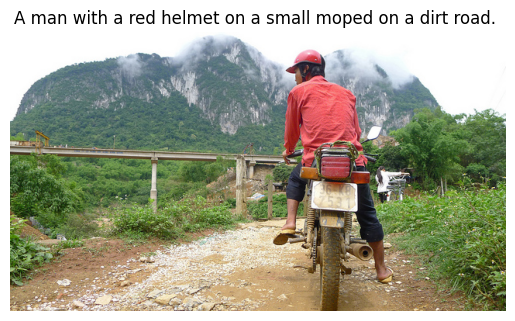

In [25]:
# 캡션 json 파일
annotation_file = './data/coco/annotations/captions_train2017.json'

# coco 객체 생성
coco = COCO(annotation_file=annotation_file)

# 이미지 id 리스트 가져오기
image_ids = list(coco.imgs.keys())

# 첫번째 이미지 id로 캡션 확인
first_img_id = image_ids[0]
ann_ids = coco.getAnnIds(imgIds=first_img_id)
annotations = coco.loadAnns(ann_ids)

# 첫번째 캡션 출력
print('caption json : ', annotations[0])
print('image id : ', first_img_id)
print('image_id : ', annotations[0]['image_id'])
print('caption : ', annotations[0]['caption'])

# 이미지 폴더 경로
image_dir = './data/coco/train2017'

# 이미지 파일 이름 가져오기
image_info = coco.loadImgs(first_img_id)[0]
file_name = image_info['file_name']

# 전체 이미지 경로
image_path = os.path.join(image_dir, file_name)

# 이미지 열기
image = Image.open(image_path).convert('RGB')

# 이미지 시각화
plt.imshow(image)
plt.axis('off')
plt.title(annotations[0])
plt.title(annotations[0]['caption'])
plt.show()

In [ ]:
# 6) Encoder-Decoder 모델 정의
# 이미지 → EncoderCNN → 특징 벡터 → DecoderRNN + 캡션 시퀀스 → 다음 단어 예측

class EncoderCNN(nn.Module): # EncoderCNN의 목적 - 이미지 → 고정 길이 특징 벡터
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # 사전학습된 ResNet-50 모델을 불러옴 - ImageNet으로 학습된 모델이므로 일반적인 이미지 특징 추출에 적합
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # ResNet의 마지막 FC (fully connected) 레이어를 제거 - 우리는 분류 결과가 아니라 중간 특징 벡터가 필요하기 때문임
        # [
        #    Conv2d(...),
        #    BatchNorm2d(...),
        #    ReLU(...),
        #    MaxPool2d(...),
        #    Layer1,
        #    Layer2,
        #    Layer3,
        #    Layer4,
        #    AdaptiveAvgPool2d(...),
        #    Linear(...)  # ← 마지막 분류 레이어 (Linear 레어어) 제거
        # ]
        modules = list(resnet.children())[:-1]

        # ResNet의 모든 파라미터를 고정시켜 학습되지 않도록 설정 
        # - 사전학습된 특징 추출기를 그대로 사용, 학습 속도 향상, 작은 데이터셋에서도 과적합 방지
        for param in resnet.parameters():
            param.requires_grad = False
        
        # 나머지 계층을 하나의 네트워크로 묶음, 이 구조는 이미지 → [batch_size, 2048, 1, 1] 형태의 특징 맵을 출력
        # [
        #    Conv2d(...),
        #    BatchNorm2d(...),
        #    ReLU(...),
        #    MaxPool2d(...),
        #    Layer1,
        #    Layer2,
        #    Layer3,
        #    Layer4,
        #    AdaptiveAvgPool2d(...)
        #    분류 레이어 (Linear 레어어) 제거 후 나머지 계층을 하나의 네트워크로 묶음
        # ]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size) # ResNet의 출력(2048차원)을 우리가 원하는 embed_size로 축소 - 예: embed_size=256이면 [batch_size, 2048] → [batch_size, 256]
        self.bn = nn.BatchNorm1d(embed_size) # 배치 정규화(BatchNorm)를 적용해 학습 안정성 향상

    def forward(self, images):
        # 특징 추출 features = self.resnet(images) - 이미지 → [batch_size, 2048, 1, 1] 형태의 특징 맵
        # 평탄화 features.reshape(images.size(0), -1) - [batch_size, 2048, 1, 1] → [batch_size, 2048]
        # - CNN의 출력은 4차원 텐서 [batch_size, channels, height, width] 
        # - 하지만 RNN 디코더에 전달하려면 2차원 벡터 [batch_size, embed_size] 형태여야 한다 
        # - 그래서 CNN 출력의 공간 차원 [1, 1]을 제거하고, 평탄화 한다.
        # images.size(0), -1 - images.size(0)는 배치 크기, -1은 Pytorch에서 -1은 자동계산(auto-infer)을 의미
        features = self.resnet(images).reshape(images.size(0), -1)

        # 차원 축소 및 정규화 - 차원 축소 Linear: [batch_size, 2048] → [batch_size, embed_size], 분포 정규화
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module): # DecoderRNN의 목적 - 이미지 특징 + 캡션 시퀀스 → 다음 단어 예측
    # embed_size: 단어 임베딩 차원(256), hidden_size: LSTM 은닉 상태 차원(512), vocab_size: 단어 사전 크기, num_layers: LSTM 레이어 수(1)
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0) # 단어 인덱스 → 임베딩 벡터로 변환, padding_idx=0는 <PAD> 토큰은 학습에서 제외
        # embed_size - 입력: [batch_size, seq_len, embed_size], 
        # hidden_size - 출력: [batch_size, seq_len+1, hidden_size] (이미지 특징 포함 시), 
        # num_layers 레이어 수, 
        # batch_first=True → 입력 텐서 shape이 [batch_size, seq_len, embed_size] 형태가 되도록 설정
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size) # LSTM의 출력 → 단어 분포로 변환 - 각 시점마다 vocab_size 차원의 확률 분포 출력

    def forward(self, captions, features): # captions: [batch_size, seq_len] (입력 캡션 인덱스 시퀀스), features: [batch_size, embed_size] (EncoderCNN의 출력)
        # 캡션 임베딩 - [batch_size, seq_len] → [batch_size, seq_len, embed_size]
        embeddings = self.embed(captions)
        # [batch_size, seq_len+1, embed_size] - 이미지 특징을 시퀀스 앞에 붙이기, features.unsqueeze(1): [batch_size, 1, embed_size]
        # 이미지 특징을 시퀀스의 첫 번째 토큰처럼 앞에 붙임, 일반적인 문장 생성과 달리, 문장의 시작점은 이미지 자체이다
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)

        # RNN(LSTM) 처리 : LSTM에 임베딩 시퀀스 입력 
        # - [batch_size, seq_len+1, embed_size] → [batch_size, seq_len+1, hidden_size]
        hiddens, _ = self.lstm(embeddings)
        # 단어 분포 예측 : 최종 출력(각 시점마다 다음 단어에 대한 확률 분포 출력) 
        # - [batch_size, seq_len+1, hidden_size] → [batch_size, seq_len+1, vocab_size]
        outputs = self.linear(hiddens)

        # 이 출력은 손실 함수(CrossEntropyLoss)와 비교되어 학습에 사용됨
        return outputs # [batch_size, seq_len+1, vocab_size] - 각 시점마다 다음 단어에 대한 확률 분포

class ImageCaptioningModel(nn.Module): # Encoder-Decoder 통합 모델 하나로 묶어 이미지 → 캡션 생성이라는 전체 파이프라인을 구성
    def __init__(self, embed_size, hidden_size, vocab_size): # embed_size: 단어 임베딩 차원(256), hidden_size: LSTM 은닉 상태 차원(512), vocab_size: 단어 사전 크기(예:10,000)
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size) # EncoderCNN 인스턴스 생성 - 이미지 → [batch_size, embed_size] 특징 벡터
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size) # DecoderRNN 인스턴스 생성 - 특징 벡터 + 캡션 시퀀스 → 다음 단어 예측

    def forward(self, images, captions):
        features = self.encoder(images) # images : [batch_size, 3, 224, 224] 크기의 이미지 텐서
        outputs = self.decoder(captions, features) # caption: [batch_size, seq_len] 크기의 캡션 인덱스 시퀀스 텐서
        return outputs
    
    # 이미지 캡셔닝 모델에서 추론(inference) 단계에 사용 
    # 이미지 → 특징 벡터 → 디코더 → 단어 예측 → 문장 생성
    # 입력 이미지 → <SOS> → "a" → "man" → "riding" → "horse" → <EOS> → [5, 6, 7, 8, 2] 형태로 반환
    def generate_caption(self, image, max_length=20): # image 단일 이미지 텐서(1, 3, 높이, 넗이), max_length: 생성할 최대 단어 수 (기본 20)
        self.eval()
        with torch.no_grad():
            features = self.encoder(image) # CNN 기반 인코더가 이미지에서 특징 벡터 추출 ([1, embed_size])
            inputs = torch.tensor([vocab.word2idx['<SOS>']]).unsqueeze(0).to(DEVICE) # <SOS> 토큰을 시작 입력으로 설정
            hidden = None # LSTM의 초기 hidden state
            generated_ids = [] # 예측된 단어 인덱스를 저장할 리스트

            # 최대 max_length만큼 반복하며 단어 생성
            # 입력: <SOS>
            #        ↓
            #        LSTM → hidden state
            #        ↓
            #        Linear → [0.01, 0.03, 0.92, 0.02, ...]  ← 단어 분포
            #        ↓
            #        Argmax → "a"
            #        ↓
            #        다음 입력: "a"

            for _ in range(max_length):
                outputs, hidden = self.decoder.lstm(self.decoder.embed(inputs), hidden) # 현재 입력 단어를 임베딩 후 LSTM에 전달
                # outputs.squeeze(1), 
                # - LSTM의 출력은 보통 [batch_size, seq_len, hidden_size] 형태 
                # - 여기서는 한 번에 한 단어씩 생성하므로 seq_len = 1 
                # - squeeze(1)을 통해 [batch_size, 1, hidden_size] → [batch_size, hidden_size]로 차원 축소
                # self.decoder.linear(), 
                # - 이 선형 계층은 hidden state → 단어 분포로 변환하는 역할, 
                # - 입력: [batch_size, hidden_size] 
                # - 출력: [batch_size, vocab_size] → 각 단어에 대한 로짓(logit) 값 (확률 전 단계)
                # 단어 분포 예측이란
                # - 모델이 다음에 올 단어를 어휘(vocab) 전체에 대해 확률적으로 예측
                outputs = self.decoder.linear(outputs.squeeze(1))
                # 가장 확률 높은 단어 선택 → 인덱스 저장
                predicted = outputs.argmax(1) # 확률이 가장 높은 단어 선택(가장 유력한 단어 선택)
                word_id = predicted.item()
                generated_ids.append(word_id)

                if word_id == vocab.word2idx['<EOS>']:
                    break
                # 다음 입력으로 현재 예측된 단어 사용
                # predicted -> 1  (단어 인덱스 하나)
                # unwqueeze -> 1,1(배치 1개, 시퀀스 길이 1개)
                # 디코더 입력 형식에 맞추기 ([batch_size, seq_len])
                inputs = predicted.unsqueeze(0)

        return generated_ids

In [35]:
# 7) 모델 하이퍼파라미터 설정 및 모델,손실함수,옵티마저 객체 생성
embed_size = 256 # 단어 임베딩 및 이미지 특징 벡터의 차원
hidden_size = 512 # RNN(LSTM)의 은닉 상태 크기
vocab_size = len(vocab.word2idx) # 전체 단어 사전 크기 (단어 개수)

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size).to(DEVICE) # 인코더 + 디코더를 포함한 전체 이미지 캡셔닝 모델
criterion = nn.CrossEntropyLoss(ignore_index=0) # CrossEntropyLoss: 다중 클래스 분류용, ignore_index=0: <PAD> 토큰은 손실 계산에서 제외
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

In [ ]:
# 8) BLEU 평가 루프
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 모델이 생성한 캡션과 정답 캡션을 비교하여 BLEU-1 ~ BLEU-4 점수를 계산
# - 평가 대상: 검증 데이터셋(val_loader)
# - 출력: 평균 BLEU 점수 4종
def evaluate_bleu(model, val_loader, vocab):
    model.eval()
    smoothie = SmoothingFunction().method4 # BLEU 점수가 0이 되는 것을 방지하기 위한 부드럽게 만드는 함수
    
    total_bleu1, total_bleu2, total_bleu3, total_bleu4 = 0, 0, 0, 0 # BLEU 점수를 누적할 변수
    sample_count = 0 # 전체 평가한 이미지 수

    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(DEVICE)

            for i in range(images.size(0)): # 배치 크기 만큼 반복
                image = images[i].unsqueeze(0)

                # 예측 캡션 생성
                # 모델이 이미지로부터 캡션 생성 (단어 인덱스 리스트)
                predicted_ids = model.generate_caption(image)
                # vocab.idx2word[idx] - 인덱스를 실제 단어로 변환,
                # if idx not in [vocab.word2idx['<PAD>'], vocab.word2idx['<SOS>'], vocab.word2idx['<EOS>']] - <PAD>, <SOS>, <EOS> 토큰은 BLEU 계산에서 제외
                predicted_caption = [vocab.idx2word[idx] for idx in predicted_ids if idx not in [vocab.word2idx['<PAD>'], vocab.word2idx['<SOS>'], vocab.word2idx['<EOS>']]]

                # 정답 캡션 준비
                target_ids = captions[i].tolist()
                # 정답 캡션도 인덱스를 단어로 변환
                reference_caption = [vocab.idx2word[idx] for idx in target_ids if idx not in [vocab.word2idx['<PAD>'], vocab.word2idx['<SOS>'], vocab.word2idx['<EOS>']]]
                # reference는 BLEU 계산을 위해 리스트 안에 리스트 형태로 구성
                reference = [reference_caption]

                # BLEU 점수 계산 
                # - BLEU-1: unigram, BLEU-2: bigram, BLEU-3: trigram, BLEU-4: 4-gram까지 고려
                # - weights는 각 BLEU 점수의 n-gram 가중치를 의미
                bleu1 = sentence_bleu(reference, predicted_caption, weights=(1, 0, 0, 0), smoothing_function=smoothie)
                bleu2 = sentence_bleu(reference, predicted_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
                bleu3 = sentence_bleu(reference, predicted_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
                bleu4 = sentence_bleu(reference, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

                # 각 이미지에 대한 BLEU 점수를 누적
                total_bleu1 += bleu1
                total_bleu2 += bleu2
                total_bleu3 += bleu3
                total_bleu4 += bleu4
                sample_count += 1 # 평가한 이미지 수 카운트

    # 평균 BLEU 점수 출력 
    # - 전체 이미지에 대한 평균 BLEU 점수 출력, 소수점 4자리까지 표시
    print(f"BLEU-1: {total_bleu1 / sample_count:.4f}")
    print(f"BLEU-2: {total_bleu2 / sample_count:.4f}")
    print(f"BLEU-3: {total_bleu3 / sample_count:.4f}")
    print(f"BLEU-4: {total_bleu4 / sample_count:.4f}")

In [37]:
# 9) 모델 학습
num_epochs = 30
patience = 3
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(num_epochs):
    # 학습 루프
    model.train()
    total_loss = 0

    for images, captions in train_loader: # train_loader에서 collate_fn()을 통해 배치 단위로 이미지와 캡션을 불러옴
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        # 예시) 원래 캡션: [1, 5, 6, 7, 8, 2]
        # - 의미 : <SOS> a man riding horse <EOS>
        # inputs = captions[:, :-1] : [1, 5, 6, 7, 8], <SOS> a man riding horse
        # targets = captions[:, 1:] : [5, 6, 7, 8, 2], a man riding horse <EOS>
        # - 모델은 <SOS>를 보고 "a"를 예측하고, "a"를 보고 "man"을 예측하고, … 이런 식으로 한 단어씩 다음 단어를 예측한다
        inputs = captions[:, :-1]
        targets = captions[:, 1:]

        outputs = model(images, inputs)
        # outputs[:, :-1, :] -> - 예측: "a", "man", "riding", "horse", <EOS>"
        loss = criterion(outputs[:, :-1, :].reshape(-1, vocab_size), targets.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # 검증 루프
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_images, val_captions in val_loader:
            val_images = val_images.to(DEVICE)
            val_captions = val_captions.to(DEVICE)

            val_inputs = val_captions[:, :-1]
            val_targets = val_captions[:, 1:]

            val_outputs = model(val_images, val_inputs)
            val_batch_loss = criterion(val_outputs[:, :-1, :].reshape(-1, vocab_size), val_targets.reshape(-1))

            val_loss += val_batch_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), './models/model_hybrid_coco.pt')  # 모델 저장
        print("✅ 모델 저장됨 (val_loss 개선)")
    else:
        patience_counter += 1
        print(f"⚠️ val_loss 개선 없음 ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break
    
    # BLEU 점수 평가
    print(f"🔍 Epoch {epoch+1} BLEU 평가:")
    evaluate_bleu(model, val_loader, vocab)


Epoch [1/30], Train Loss: 3.5523
Epoch [1/30], Val Loss: 3.2068
✅ 모델 저장됨 (val_loss 개선)
🔍 Epoch 1 BLEU 평가:
BLEU-1: 0.2762
BLEU-2: 0.0735
BLEU-3: 0.0409
BLEU-4: 0.0258
Epoch [2/30], Train Loss: 3.0521
Epoch [2/30], Val Loss: 3.1387
✅ 모델 저장됨 (val_loss 개선)
🔍 Epoch 2 BLEU 평가:
BLEU-1: 0.2520
BLEU-2: 0.0722
BLEU-3: 0.0410
BLEU-4: 0.0259
Epoch [3/30], Train Loss: 2.8563
Epoch [3/30], Val Loss: 3.1375
✅ 모델 저장됨 (val_loss 개선)
🔍 Epoch 3 BLEU 평가:
BLEU-1: 0.1404
BLEU-2: 0.0485
BLEU-3: 0.0298
BLEU-4: 0.0200
Epoch [4/30], Train Loss: 2.7056
Epoch [4/30], Val Loss: 3.1625
⚠️ val_loss 개선 없음 (1/3)
🔍 Epoch 4 BLEU 평가:
BLEU-1: 0.2154
BLEU-2: 0.0648
BLEU-3: 0.0376
BLEU-4: 0.0242
Epoch [5/30], Train Loss: 2.5831
Epoch [5/30], Val Loss: 3.2006
⚠️ val_loss 개선 없음 (2/3)
🔍 Epoch 5 BLEU 평가:
BLEU-1: 0.1165
BLEU-2: 0.0428
BLEU-3: 0.0269
BLEU-4: 0.0181
Epoch [6/30], Train Loss: 2.4789
Epoch [6/30], Val Loss: 3.2433
⚠️ val_loss 개선 없음 (3/3)
🛑 Early stopping triggered.


In [38]:
# 10) 모델 저장
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_hybrid_coco.pt')

In [39]:
# 11) 모델 로드
# 모델 구성
embed_size = 256 # 단어 임베딩 및 이미지 특징 벡터의 차원
hidden_size = 512 # RNN(LSTM)의 은닉 상태 크기
vocab_size = len(vocab.word2idx) # 전체 단어 사전 크기 (단어 개수)

model = ImageCaptioningModel(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size).to(DEVICE)

# 학습된 파라미터 로드
model.load_state_dict(torch.load('./models/model_hybrid_coco.pt'))

<All keys matched successfully>

In [82]:
# 12) 이미지 캡션 생성

# 이미지 캡셔닝 모델에서 추론(inference) 시 사용되는 핵심 함수로, 이미지 한 장을 입력받아 모델이 생성한 캡션을 문자열로 반환
# 입력 이미지 → <SOS> → "a" → "man" → "riding" → "horse" → <EOS>→ 반환: "a man riding horse"
def generate_caption_text(model, image, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        image = image.to(DEVICE).unsqueeze(0)  # [1, 3, 224, 224]
        features = model.encoder(image)        # [1, embed_size]

        # <SOS>는 문장 시작을 알리는 토큰 
        # 디코더는 이 토큰을 보고 첫 단어를 예측
        caption = [vocab.word2idx['<SOS>']]

        # 최대 max_length 만큼 반복하며 단어를 하나씩 생성
        for _ in range(max_length):
            # 현재까지 생성된 단어 시퀀스를 텐서로 변환 -> [1, seq_len]
            cap_tensor = torch.tensor(caption, dtype=torch.long).unsqueeze(0).to(DEVICE)

            # 디코더가 시퀀스와 이미지 특징을 기반으로 다음 단어 분포 예측
            output = model.decoder(cap_tensor, features)

            # 마지막 단어 위치의 로짓에서 가장 높은 확률의 단어 선택
            next_word_logits = output[0, -1, :]
            predicted_id = next_word_logits.argmax().item()

            # 예측된 단어를 캡션에 추가
            caption.append(predicted_id)
            if predicted_id == vocab.word2idx['<EOS>']: # <EOS>가 나오면 문장 종료
                break
        
        # 인덱스를 실제 단어로 변환
        result = [vocab.idx2word[idx] for idx in caption]
        return ' '.join(result[1:-1])  # <SOS>와 <EOS> 제외

Generated Caption: yellow train to tracks a train a station


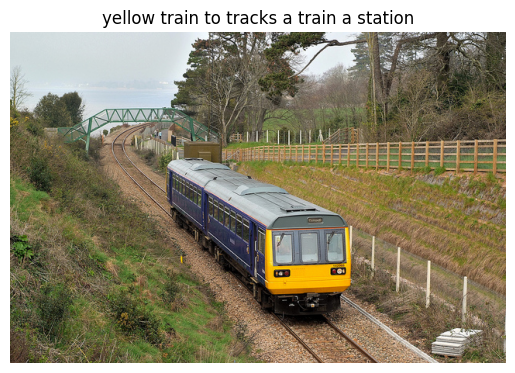

In [84]:
# 13) 이미지 시각화
# 이미지 불러오기 및 전처리 
from PIL import Image

# img_path = './data/coco/etc/1.jpg'
# img_path = './data/coco/etc/2.jpg'
# img_path = './data/coco/etc/3.jpg'
# img_path = './data/coco/etc/4.jpg'
# img_path = './data/coco/etc/5.jpg'
# img_path = './data/coco/etc/6.jpg'
# img_path = './data/coco/etc/7.jpg'
# img_path = './data/coco/etc/8.jpg'
# img_path = './data/coco/etc/9.jpg'
img_path = './data/coco/etc/10.jpg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_tensor = transform(image)

# 캡션 생성
caption = generate_caption_text(model, image_tensor, vocab)
print("Generated Caption:", caption)

# 시각화(이미지 + 캡션)
import matplotlib.pyplot as plt

def show_image_with_caption(image_path, caption):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

show_image_with_caption(img_path, caption)

In [ ]:
# 14) 이미지 캡션 생성

# coco 캡션 로더 
def load_coco_annotations(json_path):
    import json
    with open(json_path, 'r') as f:
        return json.load(f)

# 정답 캡션 추출
def get_reference_captions(coco_data, img_path):
    img_id = int(img_path.split('/')[-1].split('.')[0])
    return [ann['caption'] for ann in coco_data['annotations'] if ann['image_id'] == img_id]

# 캡션 생성 함수
def generate_caption_text_view(model, image_tensor, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        image = image_tensor.to(DEVICE).unsqueeze(0)
        features = model.encoder(image)

        caption = [vocab.word2idx['<SOS>']]
        for _ in range(max_length):
            cap_tensor = torch.tensor(caption, dtype=torch.long).unsqueeze(0).to(DEVICE)
            output = model.decoder(cap_tensor, features)
            next_word_logits = output[0, -1, :]
            predicted_id = next_word_logits.argmax().item()

            caption.append(predicted_id)
            if predicted_id == vocab.word2idx['<EOS>']:
                break

        result = [vocab.idx2word[idx] for idx in caption]
        return ' '.join(result[1:-1])

# 이미지 시각화 - 정답 비교
def show_image_with_predictions(image_path, predicted_caption, reference_captions):
    import matplotlib.pyplot as plt
    from PIL import Image

    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')

    ref_text = '\n'.join([f"• {cap}" for cap in reference_captions])
    full_caption = f"🔵 예측: {predicted_caption}\n🟢 정답:\n{ref_text}"
    print('full_caption : ', full_caption)

    plt.title(full_caption, fontsize=10, loc='left')
    plt.tight_layout()
    plt.show()

full_caption :  🔵 예측: cat on of in with and shoes a .
🟢 정답:
• A couple of cats laying on top of a pink blanket.
• There are two cats laying down with two remotes
• Two cats sleeping with a remote control near each of them.
•  two cats lying near two remotes on a purple sheets
• Two cats asleep on a sofa with a blanket on it.


C:\Users\AI\AppData\Local\Temp\ipykernel_9380\746473854.py:15: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AI\AppData\Local\Temp\ipykernel_9380\746473854.py:15: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AI\AppData\Local\Temp\ipykernel_9380\746473854.py:15: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AI\AppData\Local\Temp\ipykernel_9380\746473854.py:15: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AI\AppData\Local\Temp\ipykernel_9380\746473854.py:15: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AI\AppData\Local\Temp\ipykernel_9380\746473854.py:15: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.

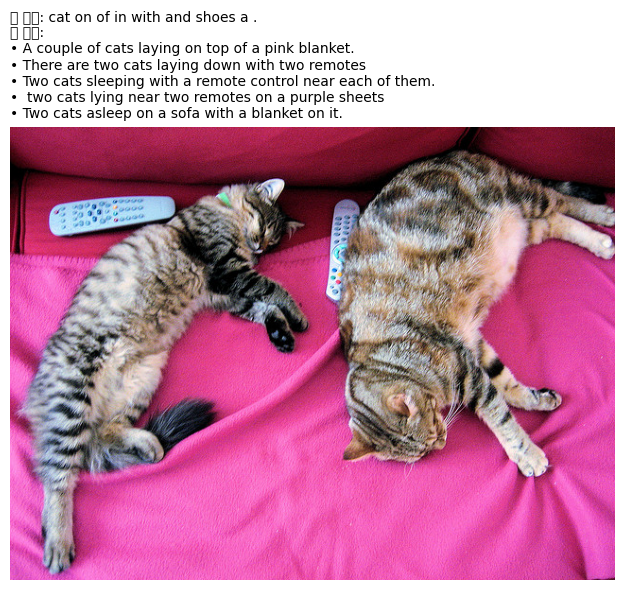

In [85]:
# 15) 이미지 캡션 생성 및 시각화 비교

# 경로 설정
img_path = './data/coco/val2017/000000039769.jpg'
json_path = './data/coco/annotations/captions_val2017.json'

# 이미지 전처리
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image = Image.open(img_path).convert('RGB')
image_tensor = transform(image)

# 캡션 생성 및 시각화
coco_data = load_coco_annotations(json_path)
reference_captions = get_reference_captions(coco_data, img_path)
predicted_caption = generate_caption_text_view(model, image_tensor, vocab)
show_image_with_predictions(img_path, predicted_caption, reference_captions)